In [3]:
%matplotlib inline
import numpy as np
from kf_book.book_plots import figsize, set_figsize
import kf_book.book_plots as book_plots
import matplotlib.pyplot as plt
from filterpy.discrete_bayes import update, predict, normalize

# 离散贝叶斯理论 (Discrete Bayes Filter)
---

这一章内容基于贝叶斯条件概率理论和全概率理论建立的Discrete_Bayes Filter。  
Discrete_Bayes Filter based on Bayesian conditional probability theory and Full probability theory.

### - 条件概率理论 conditional probability theory
>**Bayes Theorem** is  
$$P(x_{i+1} \mid Z) = \frac{P(Z \mid x_i) P(x_i)}{P(Z)}$$  


我们可以发现，**贝叶斯理论**正好表达的是这样的一个过程：  

We can see that Bayesian theory just expresses such a process:
$$ \mathtt{posterior} = normalization( \mathtt{likelihood}\times \mathtt{prior} )$$ 
这正好是后验假设的过程，即：  

This happens to be the process of the posterior hypothesis, as:
>在测量值为Z的情况下，下一个状态值为$x_{i+1}$的可能性 **=** 当前状态$x_i$存在的可能性 **$\times$** 在当前状态存在的前提下,下一状态测量值为$z$的可能性  

>In the case where the measured value is Z, the probability that the next state value $x_{i+1}$**=** the possibility of the current state $x_i$ **$\times$** the possibility that the next state measurement is $z$ on the premise of existence of the current state 

### - 全概率理论 Full probability theory
>**Total Probability Theorem** is 
$$P(x_i^{t+1}) = \sum_j P(x_i^{t+1} | x_j^{t})  P(x_j^{t})$$

这正好表达的是先验假设的过程，即：  

This just expresses the process of a priori hypothesis, as:

>在t+1时刻，i位置的状态被描述为$x_i^{t+1}$的可能性 **$=$** 在t时刻，与i位置相关的j位置的状态被描述为描述$x_i^{t}$的可能性 **$\times$**在t时刻j位置状态存在的前提下，接下来i位置的状态也存在的可能性  

>At time t+1, the possibility that the state of the i-th position is described as $x_i^{t+1}$ = at time t, the possibility that the state of the j-th position associated with the i-th position is described as $x_i^{t}\times$ the possibility that the next state is i-th position, in the premise that the state of the j-th position is present.


因此，Discrete_Bayes Filter可以用来估计这样一类问题，即：  
一个物体在一个确定的轨道上，从未知的某个地方开始，以差不多稳定的速度单向运动，其中速度也可能短时低概率地逆向行驶。  

Therefore, Discrete_Bayes Filter can be used to estimate such problems:  
An object moves in a certain orbit from a certain unknown point and moves in a one-way direction at a nearly constant speed, where the speed may also reverse in a short period of time with a low probability.

其中重要的三个函数分别为：  

The three important functions are:
``` python
from filterpy.discrete_bayes import update, predict

likelihood = lh_hallway(hallway, z, z_prob);  #$P(Z \mid x_i)$
prior = predict(posterior, move, *kernel); # $P(x_i)$
posterior = undate(likelihood,prior);  #$P(x_i \mid Z)$
```

其中，`hallway`是由离散点描述的确定的轨道，`z`是相应轨道描述，每次采样得到当前位置状态的测量值，`z_prob`是测量状态的可信度，`move`是移动速度假设，`*kernel`描述在t时间如果状态是j，那么接下来的状态是i的可能性。

where `hallway` is a defined orbit described by discrete points, `z` is the corresponding track description, where each sample gets the measured value of the current position state, `z_prob` is the confidence of the measurement state, `move` is the speed , `*kernel` describes the possibility that if the state is j at time t, then the next state is the possibility of i.

## Example:

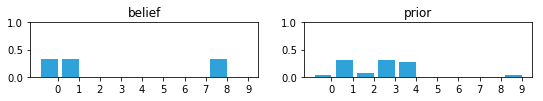

In [31]:
def predict_move(belief,move, *kernel):
    n=len(belief)
    prior = np.zeros(n)
    p_correct, p_over, p_under = kernel
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n] * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)
    return prior

belief = normalize([1,1,0,0,0,0,0,0,1,0])
#belief = normalize(np.abs(np.random.randn(10)))

prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief,prior)
set_figsize(y=1)


这个例子描述了，在t时刻每个i位置的可能性，和在t+1时刻每个i位置的可能性。kernel表示：t+1时刻，每个i位置的可能性，受到它及前后三个位置处原本状态的可能性的影响，且影响因子为0.1, 0.8, 0.1。

This example describes the probability of each i position at time t, and the probability of each i position at time t+1. The kernel indicates : at time t+1, the probability of each i-th position is affected by the possibility of the original state at three positions near it, and the influence factor is 0.1, 0.8, 0.1.

接下来，再看一下连续测量后，估计当前可能位置的例子: 

Next, let's look at an example of estimating the current possible position after continuous measurement:

[1 0 1 0 0 1 0 1 0 0]


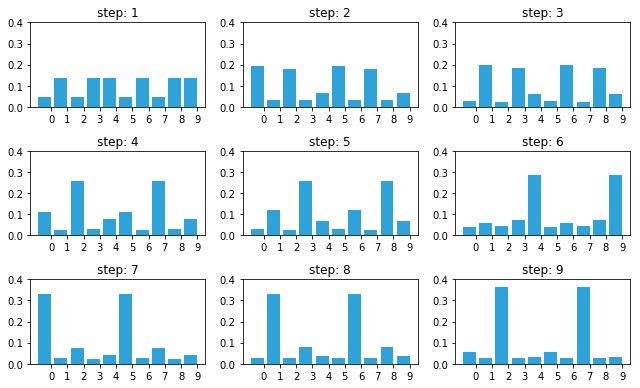

In [32]:
def lh_hallway(hall,z,z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8
        
    likelihood = np.ones(len(hall))
    likelihood[hall == z] *= scale
    return likelihood


with figsize(y=5.5):
    hallway = np.asarray([1, 0, 1, 0, 0]*2)   #表达的是一个由五个离散点来描述的循环轨道。
    prior = np.asarray([.1]*10)
    offset = 1
    kernel = np.asarray([.1, .8, .1])
    measurement = [0, 1, 0, 1, 0, 0, 1, 0, 1]  #表达的是连续九次测量，每次测量到当前所处位置的状态。
    for i, m in enumerate(measurement):
        likelihood = lh_hallway(hallway, z=m, z_prob=0.75)
        posterior = update(likelihood,prior)
        prior = predict(posterior, offset, kernel)
        plt.subplot(3,3,i+1)
        book_plots.bar_plot(posterior,ylim=(0,.4),title='step: {}'.format(i+1))
    plt.tight_layout() #区别在于，可以让个子图彼此分离，不至于title和图片重叠
print(hallway)


为了更好验证题设，我们倒着来看。  

In order to better verify the title, we look backwards.
>measurement = [0, 1, 0, 1, 0, 0, 1, 0, 1]  
表示：第2、4、7、9时刻所在的位置状态为1，其他时刻所在的位置状态为0  
Indicates that the position of the second, fourth, seventh, and ninth moments is 1, and the position of the other time is 0.
hallway = [1 0 1 0 0 1 0 1 0 0]  
表示：位置0、2、5、7处状态值为1，其他地方为0  
Indicates that the status value is 0 at positions 0, 2, 5, and 7 and 0 at other places.

我们逆向来看measurement和图，我们可以发现：  
测量值为1，出现的最大概率在2位置和7位置，由于我们知道轨道是五个离散点描述的循环轨道，所以，2位置和7位置是一个位置。2位置符合hallway应有的状态
，接着前一刻的测量值为0，出现的最大概率在1位置，而1位置也符合hallway应有的状态。  
依次向前，我们可以发现，随着测量次数的增多，无论测量是否存在误差，结果都会更加逼近于准确估计。  

We look reversely at the measurement and the figures, we can find:
The measured value is 1, and the position of the maximum probability is at the 2-nd position and the 7-th position. Since we know that the orbit is a circular orbit described by five discrete points, the 2-nd position and the 7-th position are a same position. the 2-nd position is satisfied with the condition, and then the measured value of the previous moment is 0, so the position of the maximum probability is 1-st position, and the 1-st position is also satisfied with the condition.
Looking forward, we can see that as the number of measurements increases, the result will be closer to an accurate estimate, regardless of whether there is an error in the measurement.

这个估计方法，我们通常可以用在流水线上，我们可能不知道他从哪里开始的，但是多次测量后，便可以知晓。

This estimation method, we can usually use on the assembly line, we may not know where he started, but after many measurements, you can know.